# Предобработка и классификация: KNN и Decision Tree

Файл выполняет все шаги, которые вы описали в задании. Каждое задание подписано в ноутбуке.

**Как использовать:** поместите `база.csv` рядом с этим ноутбуком и выполните все ячейки (Kernel -> Run All).


In [1]:
# Ячейка: Импорты
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
print("Рабочая директория:", os.getcwd())

Рабочая директория: /Users/platonkapustin/Data_analysis/lab_7


In [2]:

csv_path = "encoded-База.csv"
if not os.path.exists(csv_path):
    print(f"Файл '{csv_path}' не найден в рабочей директории. Пожалуйста, поместите его рядом с ноутбуком и запустите снова.")
else:
    df = pd.read_csv(csv_path, sep=";", decimal=",")
    display(df.head())
    print("Размер датасета:", df.shape)

,УИД_Брони,ДатаБрони,ВремяБрони,ИсточникБрони,ВременнаяБронь,СледующийСтатус,Город,ВидПомещения,Тип,ПродаваемаяПлощадь,...,СтоимостьНаДатуБрони,ТипСтоимости,ВариантОплаты,ВариантОплатыДоп,СкидкаНаКвартиру,ФактическаяСтоимостьПомещения,СделкаАН,ИнвестиционныйПродукт,Привилегия,Статус лида (из CRM)
0,d192173f-fc14-11eb-9512-000c29ad50ac,13.08.2021,1:00:01,ручная,Да,Свободна,Ярославль,жилые помещения,"2,5к",72.0,...,4296100.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4296100.0,Нет,Нет,Нет,S
1,43574a1f-fe8b-11eb-9512-000c29ad50ac,16.08.2021,4:12:46,ручная,Да,Свободна,Ярославль,жилые помещения,"3,5к",79.8,...,5279600.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5279600.0,Да,Нет,Нет,F
2,0e7b7a81-fe97-11eb-9512-000c29ad50ac,16.08.2021,5:37:12,ручная,Да,Свободна,Ярославль,жилые помещения,"2,5к",65.4,...,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,S
3,c7041428-f90b-11eb-9512-000c29ad50ac,09.08.2021,4:17:35,ручная,Да,Свободна,Тюмень,жилые помещения,"2,5к",61.6,...,5414500.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5414500.0,Нет,Нет,Нет,S
4,60090518-fe8b-11eb-9512-000c29ad50ac,16.08.2021,4:13:35,ручная,Да,Свободна,Ярославль,жилые помещения,"2,5к",65.4,...,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,P


Размер датасета: (5519, 21)


## 2. Предварительная фильтрация

a) Оставляем только строки, где `ВидПомещения` == 'жилые помещения'.

b) Убираем строки, где `СледующийСтатус` пуст или равен 'В резерве'. В оставшихся заменяем 'Продана'->1, 'Свободна'->0.

c) Удаляем/не используем `УИД_Брони`. Каждое действие подписано.

In [3]:

try:
    df_orig = df.copy()
except NameError:
    raise RuntimeError("Датасет df не загружен. Сначала выполните ячейку загрузки 'база.csv'.")

mask_res = df['ВидПомещения'] == 'жилые помещения'
df = df[mask_res].copy()
print("После фильтра по 'жилые помещения':", df.shape)

if 'ВидПомещения' in df.columns:
    df.drop(columns=['ВидПомещения'], inplace=True)


def is_undefined_status(x):
    if pd.isna(x): return True
    if isinstance(x, str) and x.strip() == 'В резерве': return True
    return False

mask_defined = ~df['СледующийСтатус'].apply(is_undefined_status)
df = df[mask_defined].copy()
print("После удаления неопределённых статусов:", df.shape)

df['СледующийСтатус'] = df['СледующийСтатус'].replace({'Продана':1, 'Свободна':0})

if 'УИД_Брони' in df.columns:
    df.drop(columns=['УИД_Брони'], inplace=True)

df.reset_index(drop=True, inplace=True)
display(df.head())

После фильтра по 'жилые помещения': (4105, 21)
После удаления неопределённых статусов: (3944, 20)


/var/folders/_4/q5bzk7rx44s7kbm8qbfh8yfh0000gn/T/ipykernel_49509/148514776.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['СледующийСтатус'] = df['СледующийСтатус'].replace({'Продана':1, 'Свободна':0})


,ДатаБрони,ВремяБрони,ИсточникБрони,ВременнаяБронь,СледующийСтатус,Город,Тип,ПродаваемаяПлощадь,Этаж,СтоимостьНаДатуБрони,ТипСтоимости,ВариантОплаты,ВариантОплатыДоп,СкидкаНаКвартиру,ФактическаяСтоимостьПомещения,СделкаАН,ИнвестиционныйПродукт,Привилегия,Статус лида (из CRM)
0,13.08.2021,1:00:01,ручная,Да,0,Ярославль,"2,5к",72.0,3.0,4296100.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4296100.0,Нет,Нет,Нет,S
1,16.08.2021,4:12:46,ручная,Да,0,Ярославль,"3,5к",79.8,2.0,5279600.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5279600.0,Да,Нет,Нет,F
2,16.08.2021,5:37:12,ручная,Да,0,Ярославль,"2,5к",65.4,18.0,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,S
3,09.08.2021,4:17:35,ручная,Да,0,Тюмень,"2,5к",61.6,12.0,5414500.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5414500.0,Нет,Нет,Нет,S
4,16.08.2021,4:13:35,ручная,Да,0,Ярославль,"2,5к",65.4,18.0,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,P


## 3. Преобразование типов и кодирование

a) Проверяем числовые поля.

b) Кодирование бинарных признаков (0/1).

c) One-hot кодирование для категориальных непростых признаков.

Специальная обработка поля `Тип` — удаляем букву 'к' в конце; если значение 'с' — ставим NaN.

In [4]:

df_proc = df.copy()

df_proc.columns = df_proc.columns.str.strip()

def parse_tip(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s == 'с': return np.nan
    if s.endswith('к'):
        s2 = s[:-1]
        try:
            return float(s2)
        except:
            return np.nan
    try:
        return float(s)
    except:
        return np.nan

if 'Тип' in df_proc.columns:
    df_proc['Тип'] = df_proc['Тип'].apply(parse_tip)

num_candidates = ['ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения']
for col in num_candidates:
    if col in df_proc.columns:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')

if 'ДатаБрони' in df_proc.columns:
    df_proc['ДатаБрони'] = pd.to_datetime(df_proc['ДатаБрони'], errors='coerce')
if 'ВремяБрони' in df_proc.columns:
    df_proc['ВремяБрони'] = pd.to_datetime(df_proc['ВремяБрони'], format='%H:%M:%S', errors='coerce').dt.time

binary_map = {
    'ИсточникБрони': {'МП':1, 'ручная':0},
    'ВременнаяБронь': {'Да':1, 'Нет':0},
    'ТипСтоимости': {'Стоимость при 100% оплате':1, 'Стоимость в рассрочку':0},
    'ВариантОплаты': {'Единовременная оплата':1, 'Оплата в рассрочку':0},
    'СделкаАН': {'да':1, 'нет':0, 'Да':1, 'Нет':0},
    'ИнвестиционныйПродукт': {'да':1, 'нет':0, 'Да':1, 'Нет':0},
    'Привилегия': {'да':1, 'нет':0, 'Да':1, 'Нет':0},
}

for col, mp in binary_map.items():
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].map(mp).astype('Int64')

if 'Статус лида (из CRM)' in df_proc.columns:
    df_proc['Статус_лида'] = df_proc['Статус лида (из CRM)'].astype(str).str.strip()
    le = LabelEncoder()
    df_proc['Статус_лида'] = le.fit_transform(df_proc['Статус_лида'])

cat_ohe = ['Город']
for col in cat_ohe:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].astype(str).str.strip()
        ohe = pd.get_dummies(df_proc[col], prefix=col, dummy_na=False)
        df_proc = pd.concat([df_proc, ohe], axis=1)
        df_proc.drop(columns=[col], inplace=True)

if 'ВариантОплатыДоп' in df_proc.columns and 'ВариантОплаты' in df_proc.columns:
    df_proc['ВариантОплатыДоп'] = df_proc['ВариантОплатыДоп'].fillna(df_proc['ВариантОплаты'])
    df_proc['ВариантОплатыДоп'] = df_proc['ВариантОплатыДоп'].astype(str).str.strip()
    ohe2 = pd.get_dummies(df_proc['ВариантОплатыДоп'], prefix='ВариантОплатыДоп', dummy_na=False)
    df_proc = pd.concat([df_proc, ohe2], axis=1)
    df_proc.drop(columns=['ВариантОплатыДоп'], inplace=True)

display(df_proc.head())
print(df_proc.dtypes) 

/var/folders/_4/q5bzk7rx44s7kbm8qbfh8yfh0000gn/T/ipykernel_49509/1723213122.py:29: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_proc['ДатаБрони'] = pd.to_datetime(df_proc['ДатаБрони'], errors='coerce')


,ДатаБрони,ВремяБрони,ИсточникБрони,ВременнаяБронь,СледующийСтатус,Тип,ПродаваемаяПлощадь,Этаж,СтоимостьНаДатуБрони,ТипСтоимости,...,Город_Тверь,Город_Тюмень,Город_Уфа,Город_Хабаровск,Город_Ярославль,ВариантОплатыДоп_0.0,ВариантОплатыДоп_1.0,ВариантОплатыДоп_nan,ВариантОплатыДоп_Вторичное жилье,ВариантОплатыДоп_Ипотека
0,2021-08-13,01:00:01,0,1,0,NaN,72.0,3.0,4296100.0,1,...,False,False,False,False,True,False,True,False,False,False
1,2021-08-16,04:12:46,0,1,0,NaN,79.8,2.0,5279600.0,1,...,False,False,False,False,True,False,True,False,False,False
2,2021-08-16,05:37:12,0,1,0,NaN,65.4,18.0,4201400.0,1,...,False,False,False,False,True,False,True,False,False,False
3,2021-08-09,04:17:35,0,1,0,NaN,61.6,12.0,5414500.0,1,...,False,True,False,False,False,False,True,False,False,False
4,2021-08-16,04:13:35,0,1,0,NaN,65.4,18.0,4201400.0,1,...,False,False,False,False,True,False,True,False,False,False


ДатаБрони                           datetime64[ns]
ВремяБрони                                  object
ИсточникБрони                                Int64
ВременнаяБронь                               Int64
СледующийСтатус                              int64
Тип                                        float64
ПродаваемаяПлощадь                         float64
Этаж                                       float64
СтоимостьНаДатуБрони                       float64
ТипСтоимости                                 Int64
ВариантОплаты                                Int64
СкидкаНаКвартиру                           float64
ФактическаяСтоимостьПомещения              float64
СделкаАН                                     Int64
ИнвестиционныйПродукт                        Int64
Привилегия                                   Int64
Статус лида (из CRM)                        object
Статус_лида                                  int64
Город_Ижевск                                  bool
Город_Набережные Челны         

## 4. Проверка и обработка пропусков

a) СкидкаНаКвартиру -> заменить на 0

b) Тип и ПродаваемаяПлощадь -> заменить на медиану

c) ВариантОплатыДоп обработан ранее (заменён из ВариантОплаты)

d) Остальные — если немного пропусков — удалим строки.

In [5]:
# Задание 4: Пропуски
df_mv = df_proc.copy()

# a) СкидкаНаКвартиру -> 0
if 'СкидкаНаКвартиру' in df_mv.columns:
    df_mv['СкидкаНаКвартиру'] = df_mv['СкидкаНаКвартиру'].fillna(0)

# b) Тип и ПродаваемаяПлощадь -> медиана
for col in ['Тип', 'ПродаваемаяПлощадь']:
    if col in df_mv.columns:
        med = df_mv[col].median(skipna=True)
        df_mv[col] = df_mv[col].fillna(med)
        print(f"Колонка {col}: медиана = {med}")

# c) ВариантОплатыДоп уже обработан ранее в transformation (если был)
# d) Остальные пропуски: посмотрим, сколько и решим
miss = df_mv.isna().sum()
display(miss[miss>0])
# Если мало пропусков, удалим строки
total_rows = df_mv.shape[0]
rows_with_na = df_mv[df_mv.isna().any(axis=1)].shape[0]
print(f"Всего строк: {total_rows}, строки с пропусками: {rows_with_na}")
# Удалим строки с пропусками, если их немного (меньше 5%)
if rows_with_na/total_rows < 0.05:
    df_mv.dropna(inplace=True)
    print("Удалили строки с пропусками (меньше 5% от датасета). Новая форма:", df_mv.shape)
else:
    print("Оставляем строки с пропусками — их >5%, они были заполнены для ключевых колонок.")

Колонка Тип: медиана = 2.0
Колонка ПродаваемаяПлощадь: медиана = 60.5


ВариантОплаты            3
Статус лида (из CRM)    51
dtype: int64

Всего строк: 3944, строки с пропусками: 54
Удалили строки с пропусками (меньше 5% от датасета). Новая форма: (3890, 32)


## 5. Дополнение данных

a) Добавляем признак `Цена за квадратный метр` = `ФактическаяСтоимостьПомещения` / `ПродаваемаяПлощадь`.

b) Добавляем `Скидка в процентах` = `СкидкаНаКвартиру` / `СтоимостьНаДатуБрони` (или на `СтоимостьНаДатуБрони` если 0 — осторожно).

In [6]:
# Задание 5: Добавление новых признаков
df_feat = df_mv.copy()

# a) Цена за квадратный метр
if 'ФактическаяСтоимостьПомещения' in df_feat.columns and 'ПродаваемаяПлощадь' in df_feat.columns:
    df_feat['Цена_за_м2'] = df_feat['ФактическаяСтоимостьПомещения'] / df_feat['ПродаваемаяПлощадь']
else:
    df_feat['Цена_за_м2'] = np.nan

# b) Скидка в процентах
# В описании: на основе ФактическаяСтоимостьПомещения и СкидкаНаКвартиру.
# Интерпретируем как скидка_percent = СкидкаНаКвартиру / (СтоимостьНаДатуБрони)  (если СтоимостьНаДатуБрони==0 -> NaN)
if 'СкидкаНаКвартиру' in df_feat.columns and 'СтоимостьНаДатуБрони' in df_feat.columns:
    df_feat['Скидка_в_процентах'] = df_feat['СкидкаНаКвартиру'] / df_feat['СтоимостьНаДатуБрони']
else:
    df_feat['Скидка_в_процентах'] = np.nan

display(df_feat[['Цена_за_м2','Скидка_в_процентах']].head())

,Цена_за_м2,Скидка_в_процентах
0,59668.055556,0.0
1,66160.401003,0.0
2,64241.590214,0.0
3,87897.727273,0.0
4,64241.590214,0.0


## 6. Нормализация

Минимаксная нормализация к [0,1] для всех числовых признаков, кроме `СкидкаНаКвартиру` — привести к [-0.5, 0.5].

In [23]:
# Задание 6: Нормализация
df_norm = df_feat.copy()
def norm_df(df_norm):
    # Выберем числовые колонки (исключая целевую 'СледующийСтатус' и временные признаки)
    exclude_cols = ['СледующийСтатус','ДатаБрони','ВремяБрони']
    num_cols = df_norm.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in exclude_cols]
    
    # Обработаем 'СкидкаНаКвартиру' отдельно
    if 'СкидкаНаКвартиру' in num_cols:
        # масштабируем в [-0.5, 0.5] по формуле: (x - min)/(max-min) - 0.5
        col = 'СкидкаНаКвартиру'
        minv = df_norm[col].min()
        maxv = df_norm[col].max()
        if pd.isna(minv) or pd.isna(maxv) or maxv==minv:
            df_norm[col+'_scaled'] = df_norm[col]
        else:
            df_norm[col+'_scaled'] = (df_norm[col] - minv) / (maxv - minv) - 0.5
        num_cols.remove(col)
    else:
        print('Колонка СкидкаНаКвартиру отсутствует, пропускаем её специфическое масштабирование.')
    
    # Для остальных числовых колонок применим MinMaxScaler к диапазону [0,1]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    if len(num_cols)>0:
        df_norm[num_cols] = scaler.fit_transform(df_norm[num_cols])

    return df_norm
df_norm = norm_df(df_norm)
display(df_norm.head())

,ДатаБрони,ВремяБрони,ИсточникБрони,ВременнаяБронь,СледующийСтатус,Тип,ПродаваемаяПлощадь,Этаж,СтоимостьНаДатуБрони,ТипСтоимости,...,Город_Хабаровск,Город_Ярославль,ВариантОплатыДоп_0.0,ВариантОплатыДоп_1.0,ВариантОплатыДоп_nan,ВариантОплатыДоп_Вторичное жилье,ВариантОплатыДоп_Ипотека,Цена_за_м2,Скидка_в_процентах,СкидкаНаКвартиру_scaled
0,2021-08-13,01:00:01,0.0,1.0,0,0.333333,0.397864,0.083333,0.104727,1.0,...,False,True,False,True,False,False,False,0.036272,0.373058,-0.114056
1,2021-08-16,04:12:46,0.0,1.0,0,0.333333,0.467290,0.041667,0.141803,1.0,...,False,True,False,True,False,False,False,0.051763,0.373058,-0.114056
2,2021-08-16,05:37:12,0.0,1.0,0,0.333333,0.339119,0.708333,0.101157,1.0,...,False,True,False,True,False,False,False,0.047185,0.373058,-0.114056
3,2021-08-09,04:17:35,0.0,1.0,0,0.333333,0.305296,0.458333,0.146888,1.0,...,False,False,False,True,False,False,False,0.103632,0.373058,-0.114056
4,2021-08-16,04:13:35,0.0,1.0,0,0.333333,0.339119,0.708333,0.101157,1.0,...,False,True,False,True,False,False,False,0.047185,0.373058,-0.114056


## 7. Сбалансированность класса (целевой признак)

Проверим количество 0 и 1 в `СледующийСтатус`.

In [14]:
counts = df_norm['СледующийСтатус'].value_counts(dropna=False)
print(counts)

СледующийСтатус
0    2766
1    1124
Name: count, dtype: int64


## 8. Список факторных признаков и целевой признак

Сформируем X и y. Исключим временные признаки и явные идентификаторы.

In [15]:
# Задание 8: Формирование списка признаков и целевой
# Уберём нечисловые временные поля и исходные текстовые дубликаты
df_model = df_norm.copy()

drop_cols = ['ДатаБрони','ВремяБрони'] if 'ДатаБрони' in df_model.columns else []
for c in drop_cols:
    df_model.drop(columns=[c], inplace=True)

# Целевая
y = df_model['СледующийСтатус'].astype(int)
# Фичи: все остальные числовые колонки + бинарные/one-hot ранее созданные
X = df_model.drop(columns=['СледующийСтатус'])
# Оставим только числовые колонки для моделей (после one-hot они тоже числовые)
X = X.select_dtypes(include=[np.number]).copy()

print('Форма X:', X.shape)
print('Части признаков (первые 30):', X.columns[:30].tolist())


Форма X: (3890, 17)
Части признаков (первые 30): ['ИсточникБрони', 'ВременнаяБронь', 'Тип', 'ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 'ТипСтоимости', 'ВариантОплаты', 'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения', 'СделкаАН', 'ИнвестиционныйПродукт', 'Привилегия', 'Статус_лида', 'Цена_за_м2', 'Скидка_в_процентах', 'СкидкаНаКвартиру_scaled']


## 9. Разбиение на обучающую и тестовую выборки

Строки выбираются в случайном порядке. Используем test_size=0.2 и random_state=42.

In [16]:
# Задание 9: Разбиение
# Используем стратифицированное разбиение по целевой, чтобы сохранить доли классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (3112, 17) Test shape: (778, 17)


In [17]:
# 10. KNN классификатор (по умолчанию)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('KNN обучен')

KNN обучен


In [18]:
# 11. Decision Tree классификатор (по умолчанию)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print('Decision Tree обучен')

Decision Tree обучен


In [19]:
# 12. Векторы прогнозных значений для обеих моделей
y_pred_knn_train = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)

y_pred_dt_train = dt.predict(X_train)
y_pred_dt_test = dt.predict(X_test)


print('Прогнозы получены')

Прогнозы получены


In [20]:

def print_metrics(y_true, y_pred, label):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{label} -> Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}")

print('KNN на train:')
print_metrics(y_train, y_pred_knn_train, 'KNN_train')
print('KNN на test:')
print_metrics(y_test, y_pred_knn_test, 'KNN_test')

print('\nDecision Tree на train:')
print_metrics(y_train, y_pred_dt_train, 'DT_train')
print('Decision Tree на test:')
print_metrics(y_test, y_pred_dt_test, 'DT_test')

KNN на train:
KNN_train -> Precision: 0.8886, Recall: 0.8076, F1: 0.8462
KNN на test:
KNN_test -> Precision: 0.8657, Recall: 0.7733, F1: 0.8169

Decision Tree на train:
DT_train -> Precision: 1.0000, Recall: 0.9800, F1: 0.9899
Decision Tree на test:
DT_test -> Precision: 0.7609, Recall: 0.7778, F1: 0.7692


## 14. Выводы и интерпретация



15. ОБРАБОТКА ВЫБРОСОВ И ПЕРЕОБУЧЕНИЕ МОДЕЛЕЙ


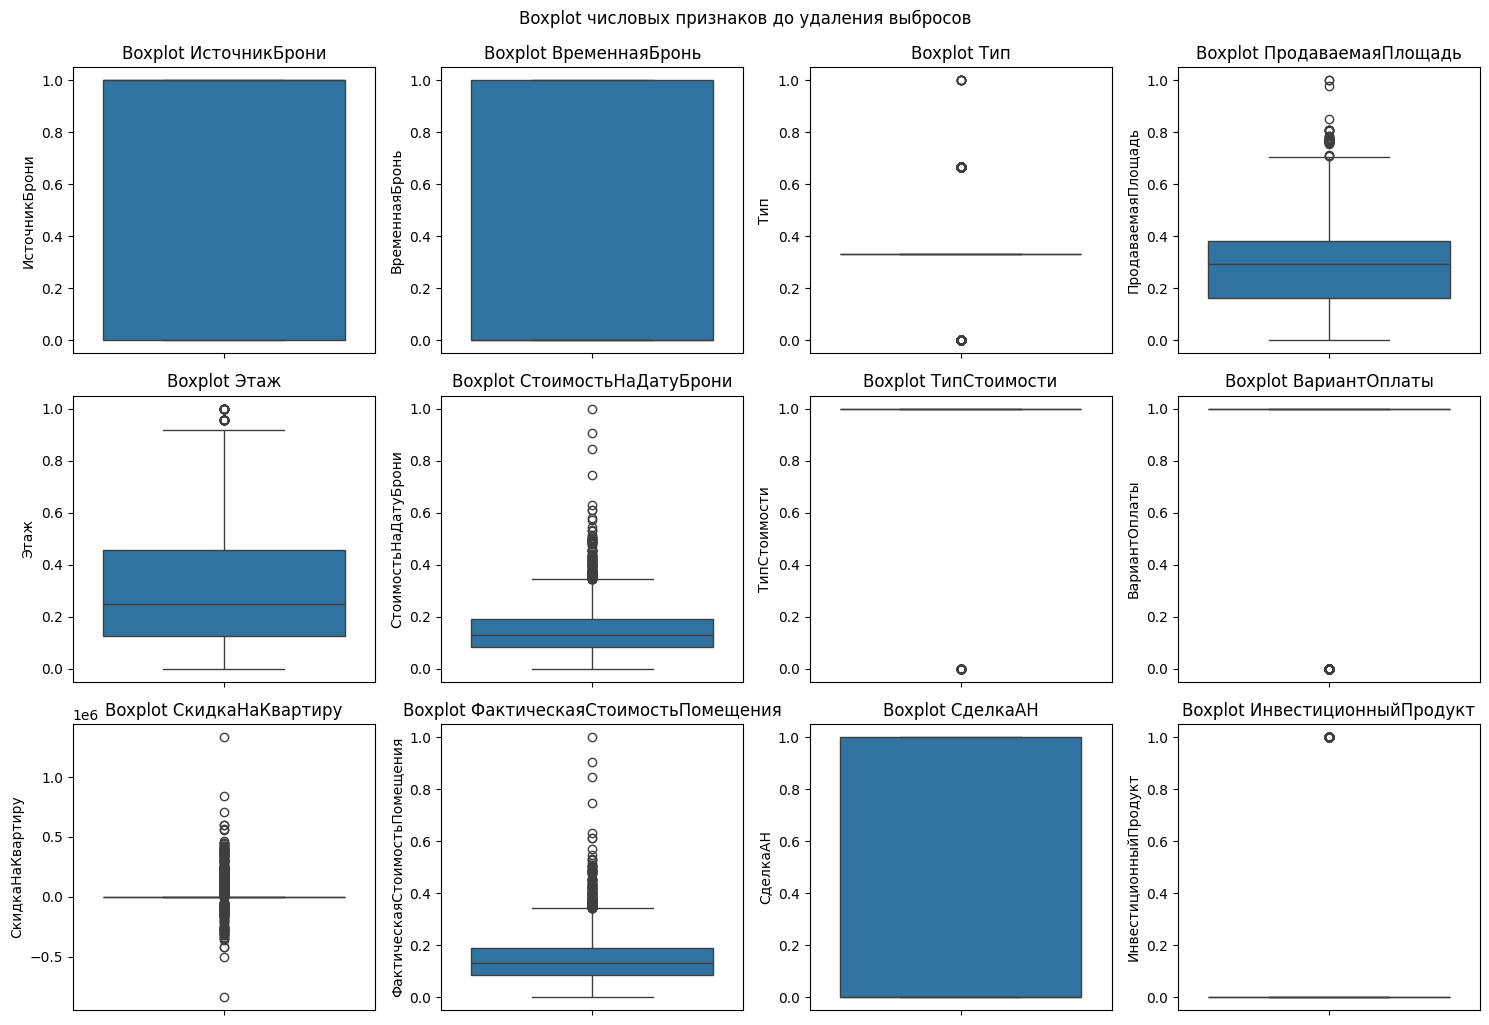

Размер данных до удаления выбросов: (3890, 17)
Размер данных после удаления выбросов: (3783, 17)
Удалено 107 строк (2.8% данных)

МЕТРИКИ ПОСЛЕ УДАЛЕНИЯ ВЫБРОСОВ:
KNN на очищенных данных:
KNN_clean -> Precision: 0.8119, Recall: 0.7489, F1: 0.7791
Decision Tree на очищенных данных:
DT_clean -> Precision: 0.7615, Recall: 0.7580, F1: 0.7597

16. ПОДБОР ПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ


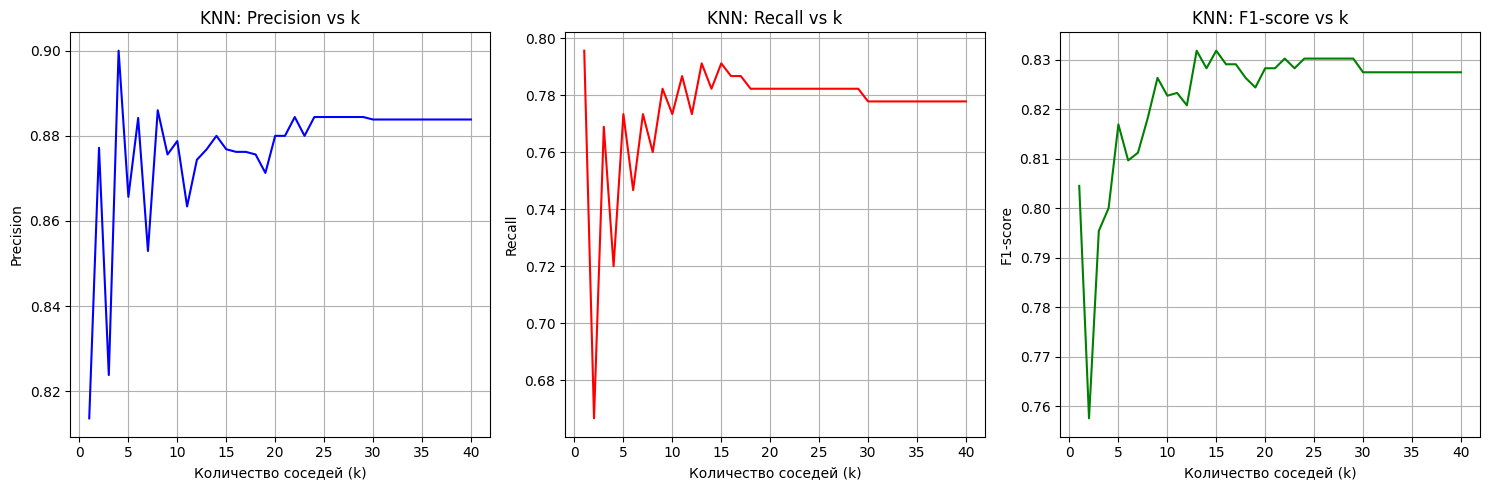

Оптимальное k для KNN: 13 (F1-score = 0.8318)


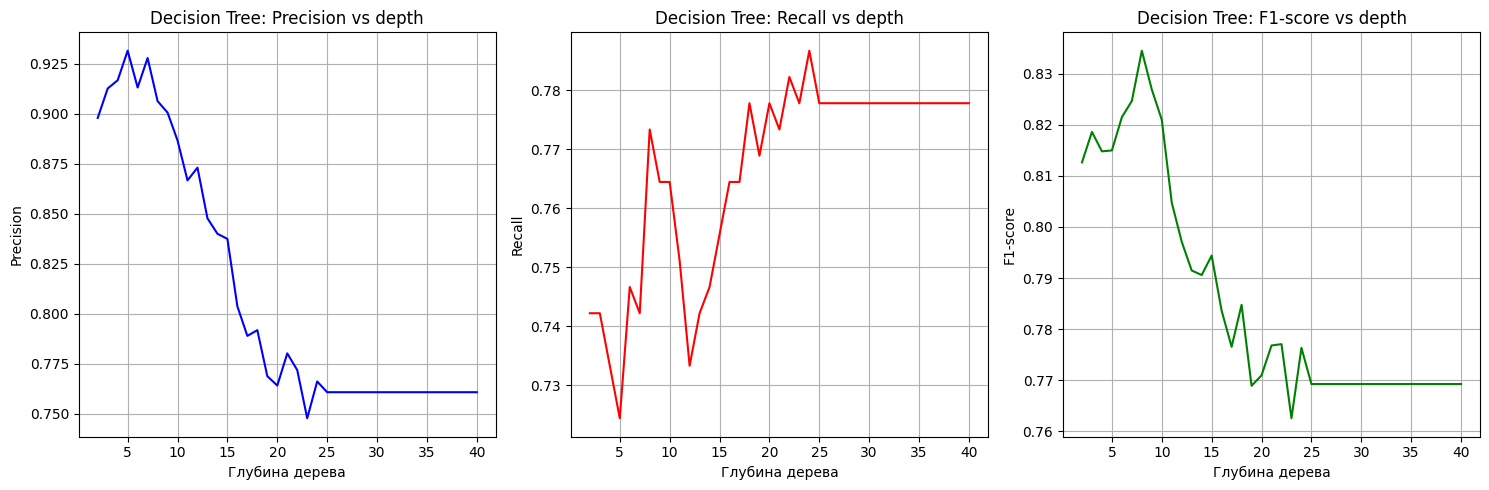

Оптимальная глубина для Decision Tree: 8 (F1-score = 0.8345)

МЕТРИКИ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ:
KNN с оптимальным k:
KNN_optimized -> Precision: 0.8768, Recall: 0.7911, F1: 0.8318
Decision Tree с оптимальной глубиной:
DT_optimized -> Precision: 0.9062, Recall: 0.7733, F1: 0.8345

17. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Логистическая регрессия:
LogisticRegression -> Precision: 0.9207, Recall: 0.6711, F1: 0.7763

18. SVM (LINEAR SVC)


/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Лучшие параметры SVM: {'C': 5000, 'class_weight': 'balanced'}
SVM_optimized -> Precision: 0.8532, Recall: 0.4133, F1: 0.5569

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
                              Model  Precision  Recall      F1
0                     KNN (базовый)     0.8657  0.7733  0.8169
1            KNN (оптимизированный)     0.8768  0.7911  0.8318
2           Decision Tree (базовый)     0.7609  0.7778  0.7692
3  Decision Tree (оптимизированный)     0.9062  0.7733  0.8345
4               Logistic Regression     0.9207  0.6711  0.7763
5                               SVM     0.8532  0.4133  0.5569


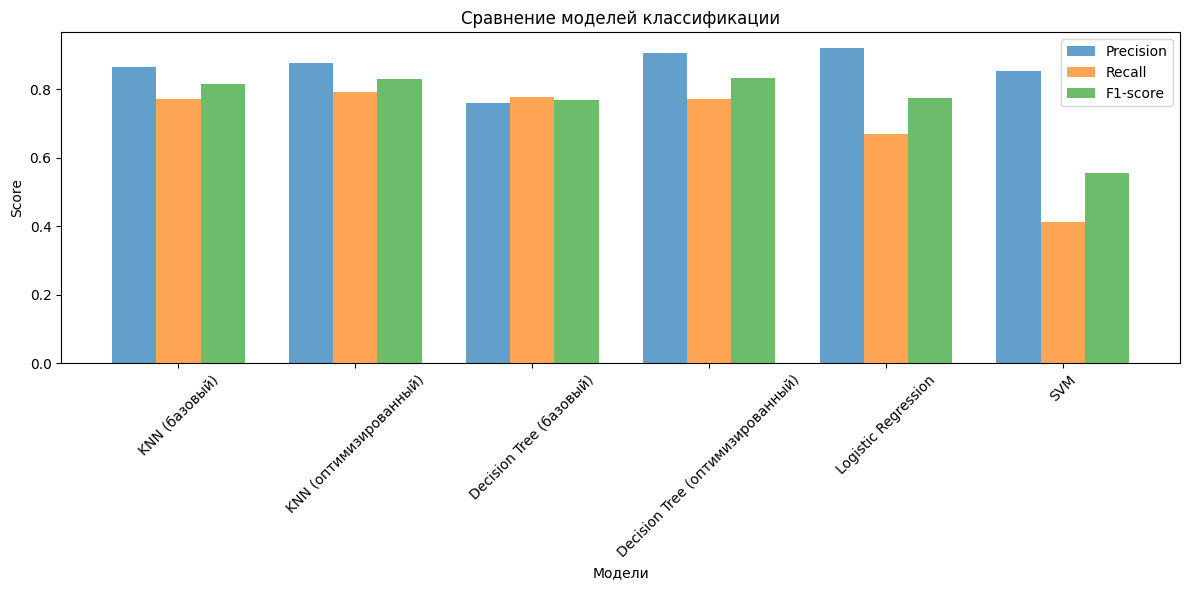

In [49]:


print("\n" + "="*60)
print("15. ОБРАБОТКА ВЫБРОСОВ И ПЕРЕОБУЧЕНИЕ МОДЕЛЕЙ")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
numeric_cols = X.select_dtypes(include=[np.number]).columns
for i, col in enumerate(numeric_cols[:12]):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=X[col])
    plt.title(f'Boxplot {col}')
    plt.tight_layout()
plt.suptitle('Boxplot числовых признаков до удаления выбросов', y=1.02)
plt.show()

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    mask = (df_clean["ПродаваемаяПлощадь"] < 0.75) & \
           (df_clean["СтоимостьНаДатуБрони"] < 0.38) & \
           (df_clean["ФактическаяСтоимостьПомещения"] < 0.39)
    
    df_clean = df_clean[mask]
    return df_clean

X_clean = remove_outliers_iqr(X, numeric_cols)
y_clean = y.loc[X_clean.index]

print(f"Размер данных до удаления выбросов: {X.shape}")
print(f"Размер данных после удаления выбросов: {X_clean.shape}")
print(f"Удалено {X.shape[0] - X_clean.shape[0]} строк ({((X.shape[0] - X_clean.shape[0])/X.shape[0]*100):.1f}% данных)")

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

knn_clean = KNeighborsClassifier()
knn_clean.fit(X_train_clean, y_train_clean)

dt_clean = DecisionTreeClassifier(random_state=42)
dt_clean.fit(X_train_clean, y_train_clean)

y_pred_knn_clean = knn_clean.predict(X_test_clean)
y_pred_dt_clean = dt_clean.predict(X_test_clean)

print("\nМЕТРИКИ ПОСЛЕ УДАЛЕНИЯ ВЫБРОСОВ:")
print("KNN на очищенных данных:")
print_metrics(y_test_clean, y_pred_knn_clean, 'KNN_clean')

print("Decision Tree на очищенных данных:")
print_metrics(y_test_clean, y_pred_dt_clean, 'DT_clean')

print("\n" + "="*60)
print("16. ПОДБОР ПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ")
print("="*60)

from sklearn.model_selection import cross_val_score

k_range = range(1, 41)
knn_scores = {'precision': [], 'recall': [], 'f1': []}

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    
    knn_scores['precision'].append(precision_score(y_test, y_pred_temp))
    knn_scores['recall'].append(recall_score(y_test, y_pred_temp))
    knn_scores['f1'].append(f1_score(y_test, y_pred_temp))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range, knn_scores['precision'], 'b-', label='Precision')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Precision')
plt.title('KNN: Precision vs k')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_range, knn_scores['recall'], 'r-', label='Recall')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Recall')
plt.title('KNN: Recall vs k')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(k_range, knn_scores['f1'], 'g-', label='F1-score')
plt.xlabel('Количество соседей (k)')
plt.ylabel('F1-score')
plt.title('KNN: F1-score vs k')
plt.grid(True)

plt.tight_layout()
plt.show()

best_k_f1 = k_range[np.argmax(knn_scores['f1'])]
print(f"Оптимальное k для KNN: {best_k_f1} (F1-score = {max(knn_scores['f1']):.4f})")

depth_range = range(2, 41)
dt_scores = {'precision': [], 'recall': [], 'f1': []}

for depth in depth_range:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    y_pred_temp = dt_temp.predict(X_test)
    
    dt_scores['precision'].append(precision_score(y_test, y_pred_temp))
    dt_scores['recall'].append(recall_score(y_test, y_pred_temp))
    dt_scores['f1'].append(f1_score(y_test, y_pred_temp))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(depth_range, dt_scores['precision'], 'b-', label='Precision')
plt.xlabel('Глубина дерева')
plt.ylabel('Precision')
plt.title('Decision Tree: Precision vs depth')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(depth_range, dt_scores['recall'], 'r-', label='Recall')
plt.xlabel('Глубина дерева')
plt.ylabel('Recall')
plt.title('Decision Tree: Recall vs depth')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(depth_range, dt_scores['f1'], 'g-', label='F1-score')
plt.xlabel('Глубина дерева')
plt.ylabel('F1-score')
plt.title('Decision Tree: F1-score vs depth')
plt.grid(True)

plt.tight_layout()
plt.show()

best_depth_f1 = depth_range[np.argmax(dt_scores['f1'])]
print(f"Оптимальная глубина для Decision Tree: {best_depth_f1} (F1-score = {max(dt_scores['f1']):.4f})")

knn_optimized = KNeighborsClassifier(n_neighbors=best_k_f1)
knn_optimized.fit(X_train, y_train)
y_pred_knn_opt = knn_optimized.predict(X_test)

dt_optimized = DecisionTreeClassifier(max_depth=best_depth_f1, random_state=42)
dt_optimized.fit(X_train, y_train)
y_pred_dt_opt = dt_optimized.predict(X_test)

print("\nМЕТРИКИ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ:")
print("KNN с оптимальным k:")
print_metrics(y_test, y_pred_knn_opt, 'KNN_optimized')

print("Decision Tree с оптимальной глубиной:")
print_metrics(y_test, y_pred_dt_opt, 'DT_optimized')

print("\n" + "="*60)
print("17. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("="*60)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Логистическая регрессия:")
print_metrics(y_test, y_pred_lr, 'LogisticRegression')

print("\n" + "="*60)
print("18. SVM (LINEAR SVC)")
print("="*60)

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [5000, 1000, 500, 100, 50, 10],
    'class_weight': [None, 'balanced']
}

svm_grid = GridSearchCV(LinearSVC(random_state=42, max_iter=10000), 
                       param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)

print("Лучшие параметры SVM:", svm_grid.best_params_)
y_pred_svm_optimized = svm_grid.predict(X_test)
print_metrics(y_test, y_pred_svm_optimized, 'SVM_optimized')

print("\n" + "="*60)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*60)

models = {
    'KNN (базовый)': y_pred_knn_test,
    'KNN (оптимизированный)': y_pred_knn_opt,
    'Decision Tree (базовый)': y_pred_dt_test,
    'Decision Tree (оптимизированный)': y_pred_dt_opt,
    'Logistic Regression': y_pred_lr,
    'SVM': y_pred_svm_optimized
}

results = []
for name, pred in models.items():
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results.append({'Model': name, 'Precision': precision, 'Recall': recall, 'F1': f1})

results_df = pd.DataFrame(results)
print(results_df.round(4))

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(results_df))
width = 0.25

plt.bar(x_pos - width, results_df['Precision'], width, label='Precision', alpha=0.7)
plt.bar(x_pos, results_df['Recall'], width, label='Recall', alpha=0.7)
plt.bar(x_pos + width, results_df['F1'], width, label='F1-score', alpha=0.7)

plt.xlabel('Модели')
plt.ylabel('Score')
plt.title('Сравнение моделей классификации')
plt.xticks(x_pos, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()